In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


import missingno as msno
from scipy.stats import norm, skew
from sklearn import metrics


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import  mean_squared_log_error
from sklearn import model_selection
from sklearn.pipeline import make_pipeline


from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.regressor import StackingCVRegressor

from termcolor import colored
# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

#to see model hyperparameters
from sklearn import set_config
set_config(print_changed_only = False)

# to show all columns
pd.set_option('display.max_columns', 15)

In [2]:
car = pd.read_csv("Car details.csv")
df = car.copy()


In [3]:
print("The number of rows in train data is {0}, and the number of columns in train data is {1}".
      format(df.shape[0], df.shape[1]))

The number of rows in train data is 8128, and the number of columns in train data is 13


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [5]:
#make dtypes of some variables 'category'

categoric_columns = ["fuel", "transmission", "owner", "seller_type"]
for column in categoric_columns:
    df[column] = df[column].astype("category")

In [6]:
#create 'car_brand_name' feature from 'name' feature

df["car_brand_name"] = df["name"].str.extract('([^\s]+)')
df["car_brand_name"] = df["car_brand_name"].astype("category")

In [7]:
#extract values of 'engine' and 'mileage' variables

df["engine"] = df["engine"].str.extract('([^\s]+)').astype("float")
df["mileage"] = df["mileage"].str.extract('([^\s]+)').astype("float")

In [8]:
#extract values of 'max_power' variable

df["max_power"] = df["max_power"].str.extract('([^\s]+)')
df["max_power"] = df["max_power"][~(df["max_power"] == "bhp")]
df["max_power"] = df["max_power"].astype("float")

In [9]:
#create 'car_age' feature from 'year' column
df['year'].max()
df["car_age"] = 2020 - (df["year"])

In [10]:
df.drop(["name", "year", "torque","seller_type","owner","seats"], axis = 1, inplace = True)

In [11]:
df.head()

,selling_price,km_driven,fuel,transmission,mileage,engine,max_power,car_brand_name,car_age
0,450000,145500,Diesel,Manual,23.40,1248.0,74.00,Maruti,6
1,370000,120000,Diesel,Manual,21.14,1498.0,103.52,Skoda,6
2,158000,140000,Petrol,Manual,17.70,1497.0,78.00,Honda,14
3,225000,127000,Diesel,Manual,23.00,1396.0,90.00,Hyundai,10
4,130000,120000,Petrol,Manual,16.10,1298.0,88.20,Maruti,13


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   selling_price   8128 non-null   int64   
 1   km_driven       8128 non-null   int64   
 2   fuel            8128 non-null   category
 3   transmission    8128 non-null   category
 4   mileage         7907 non-null   float64 
 5   engine          7907 non-null   float64 
 6   max_power       7912 non-null   float64 
 7   car_brand_name  8128 non-null   category
 8   car_age         8128 non-null   int64   
dtypes: category(3), float64(3), int64(3)
memory usage: 406.6 KB


In [13]:
# check whether there are null values in the dataset
df.isnull().sum()

selling_price       0
km_driven           0
fuel                0
transmission        0
mileage           221
engine            221
max_power         216
car_brand_name      0
car_age             0
dtype: int64

In [14]:
df.describe()

,selling_price,km_driven,mileage,engine,max_power,car_age
count,8.128000e+03,8.128000e+03,7907.000000,7907.000000,7912.000000,8128.000000
mean,6.382718e+05,6.981951e+04,19.418783,1458.625016,91.517919,6.195989
std,8.062534e+05,5.655055e+04,4.037145,503.916303,35.822499,4.044249
min,2.999900e+04,1.000000e+00,0.000000,624.000000,0.000000,0.000000
25%,2.549990e+05,3.500000e+04,16.780000,1197.000000,68.050000,3.000000
50%,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.000000,5.000000
75%,6.750000e+05,9.800000e+04,22.320000,1582.000000,102.000000,9.000000
max,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,37.000000


In [15]:
df.describe(include = "category").T

,count,unique,top,freq
fuel,8128,4,Diesel,4402
transmission,8128,2,Manual,7078
car_brand_name,8128,32,Maruti,2448


In [17]:
#fill null values with median (numeric) and frequent values (categoric)

numeric_data = [column for column in df.select_dtypes(["int", "float"])]
categoric_data = [column for column in df.select_dtypes(exclude = ["int", "float"])]

for col in numeric_data:
    df[col].fillna(df[col].median(), inplace = True)
        
#replace missing values in each categorical column with the most frequent value
for col in categoric_data:
    df[col].fillna(df[col].value_counts().index[0], inplace = True)

In [18]:
#check null values again

df.isnull().sum().sum()

0

In [19]:
#get class frequencies of some variables

print("Class frequencies of 'transmission' variable: \n\n", df["transmission"].value_counts())



print("_____________________________________________________________________________________")

print("Class frequencies of 'car_brand_name' variable: \n\n", df["car_brand_name"].value_counts())

Class frequencies of 'transmission' variable: 

 transmission
Manual       7078
Automatic    1050
Name: count, dtype: int64
_____________________________________________________________________________________
Class frequencies of 'car_brand_name' variable: 

 car_brand_name
Maruti           2448
Hyundai          1415
Mahindra          772
Tata              734
Toyota            488
Honda             467
Ford              397
Chevrolet         230
Renault           228
Volkswagen        186
BMW               120
Skoda             105
Nissan             81
Jaguar             71
Volvo              67
Datsun             65
Mercedes-Benz      54
Fiat               47
Audi               40
Lexus              34
Jeep               31
Mitsubishi         14
Land                6
Force               6
Isuzu               5
Kia                 4
Ambassador          4
MG                  3
Daewoo              3
Opel                1
Peugeot             1
Ashok               1
Name: count, dtype: 

### Boxplot

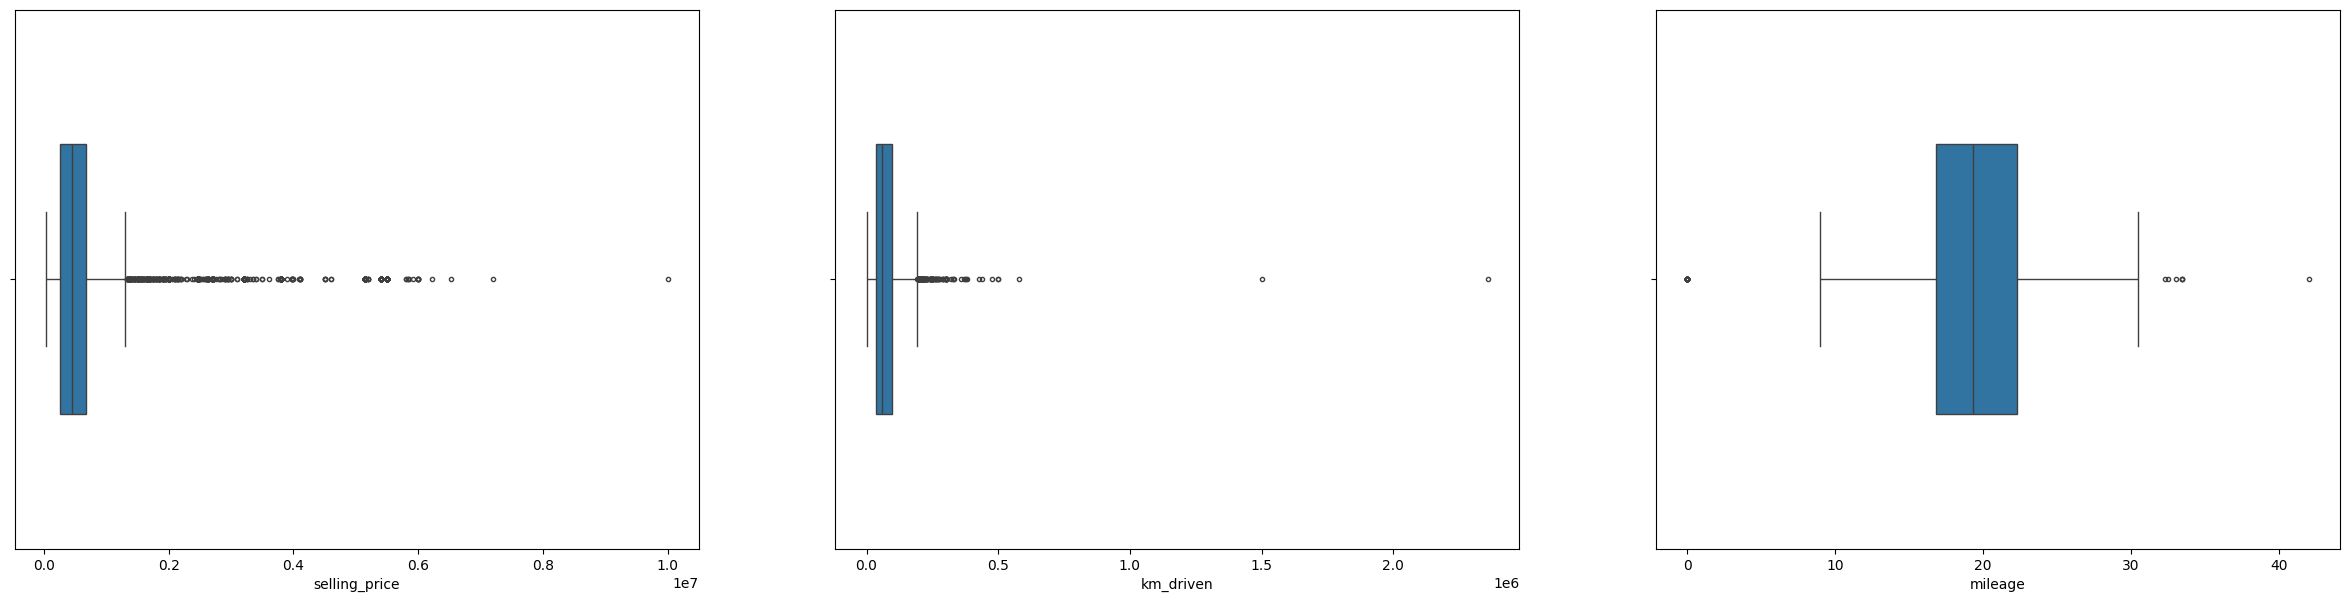

In [20]:
fig, axes = plt.subplots(1, 3, figsize = (30, 7))

sns.boxplot(ax = axes[0], x = "selling_price", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[1], x = "km_driven", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[2], x = "mileage", data = df, width = 0.5, fliersize = 3, linewidth = 1);

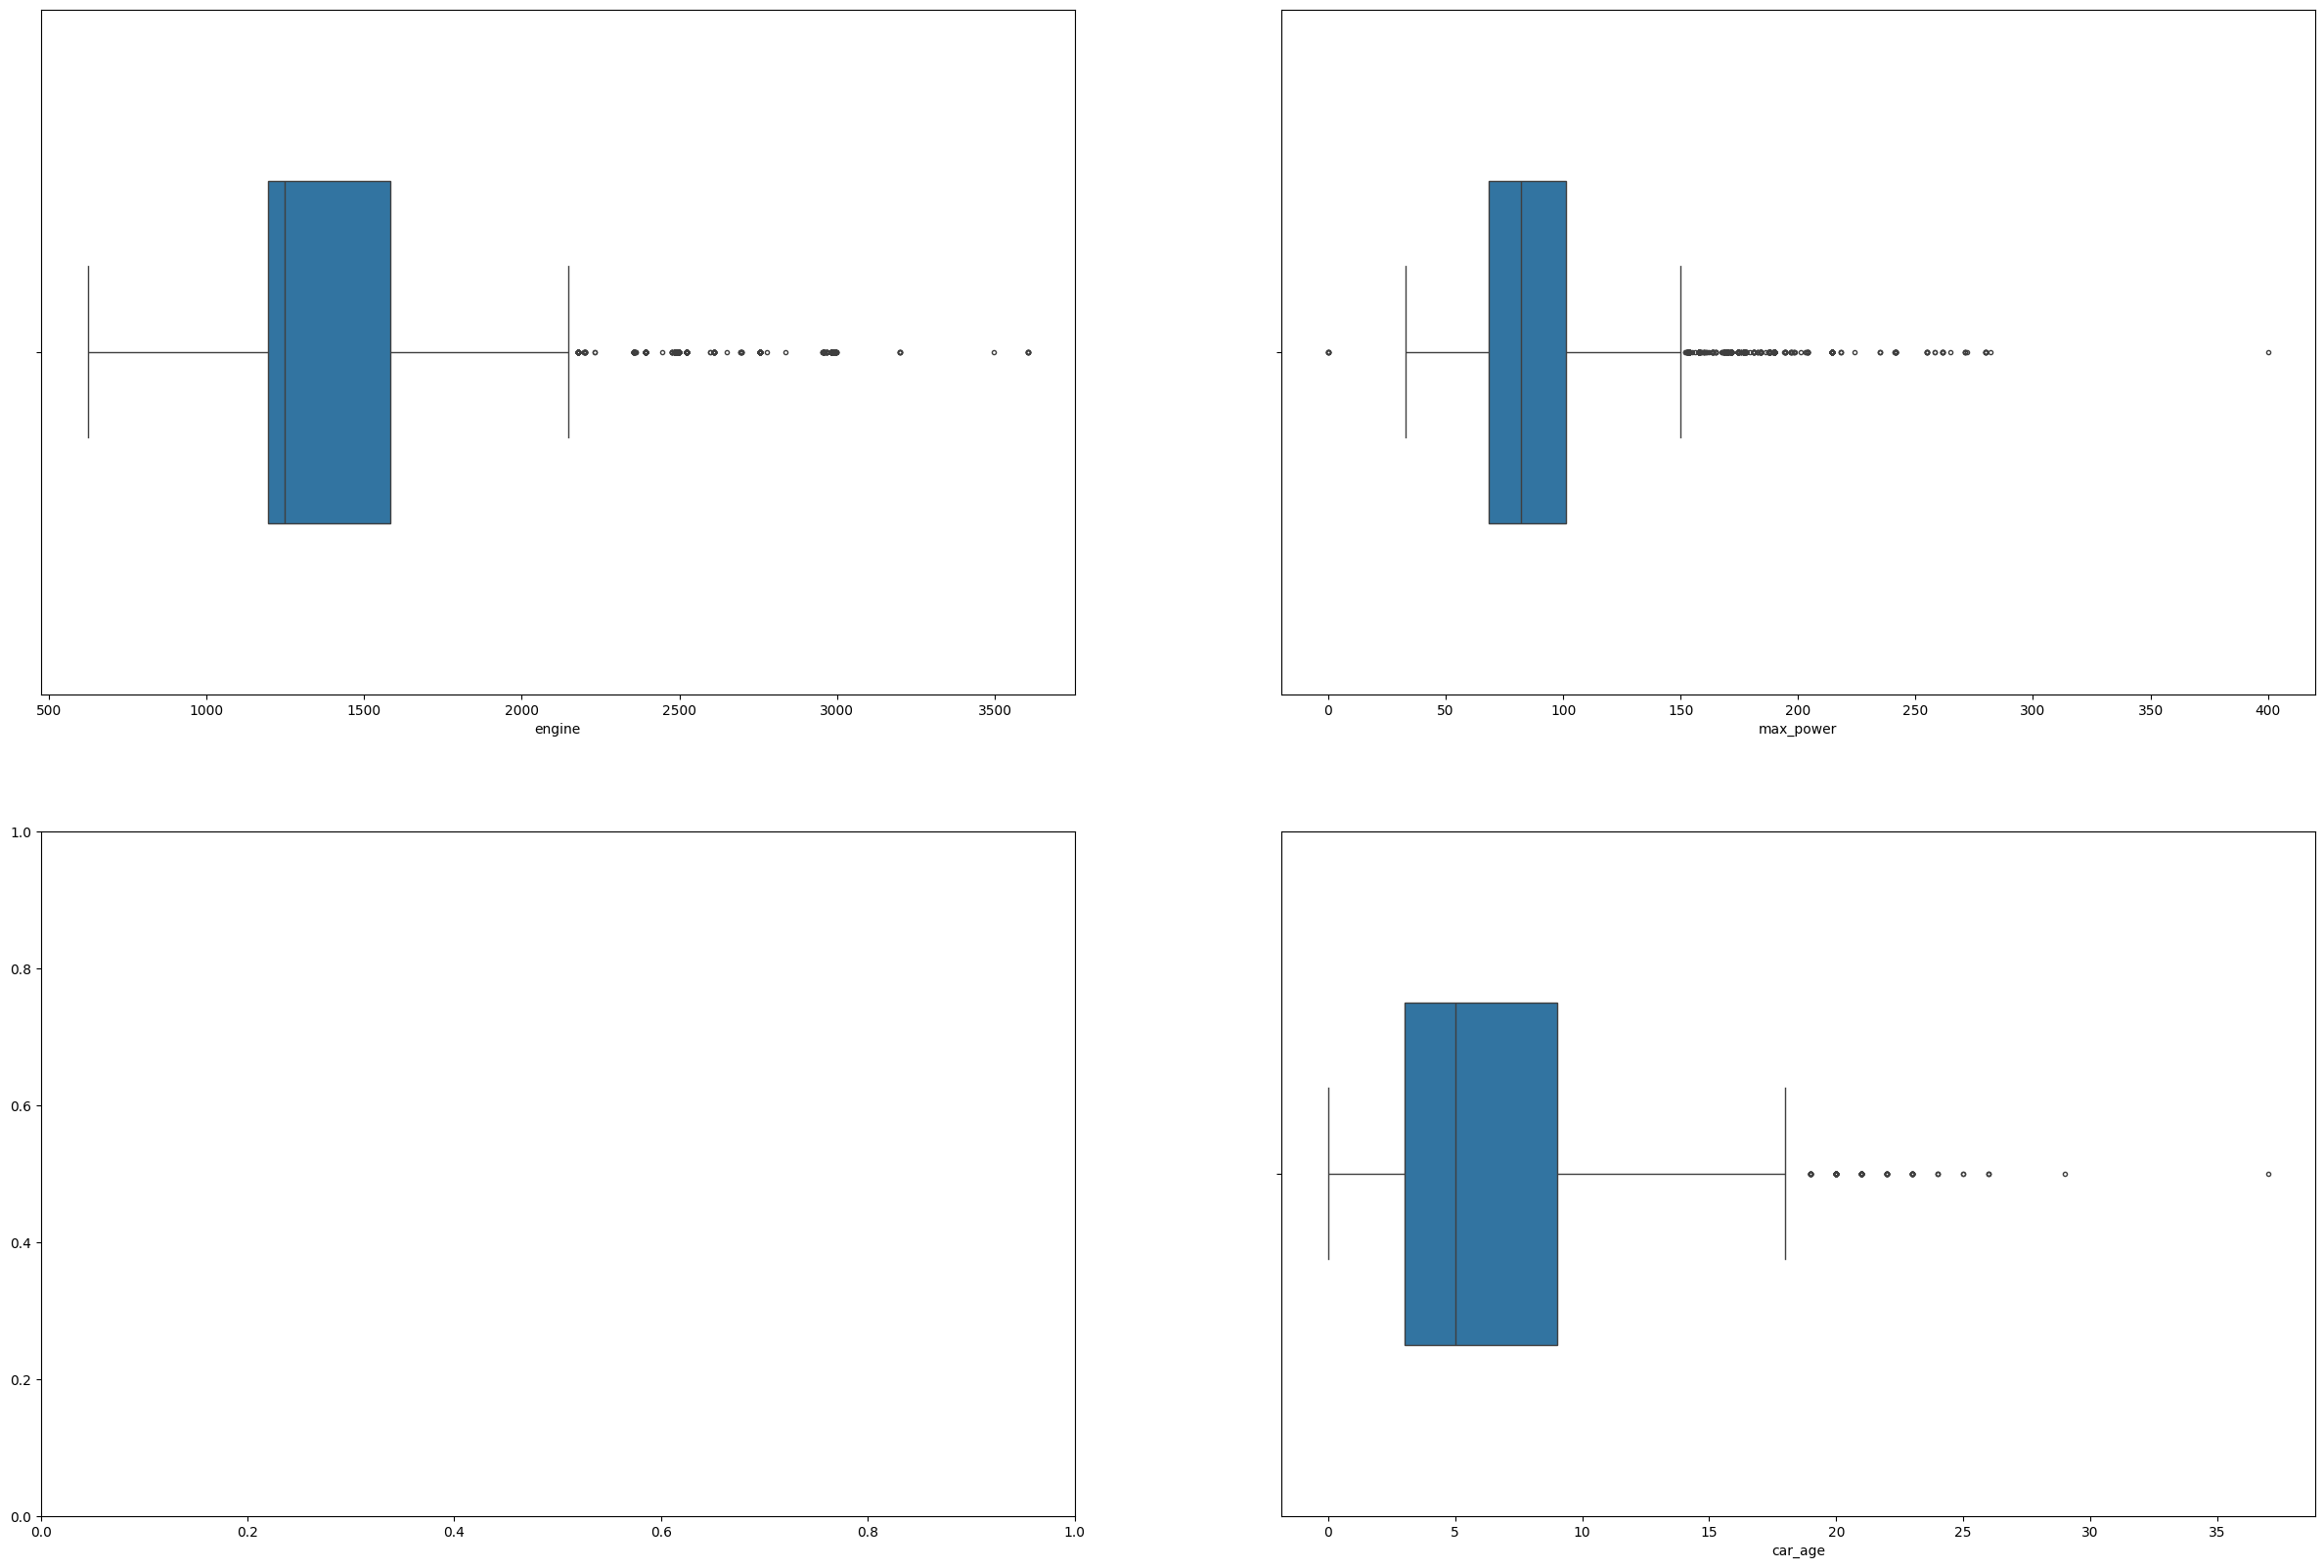

In [21]:
fig, axes = plt.subplots(2, 2, figsize = (30, 20))
axes = axes.flatten()

sns.boxplot(ax = axes[0], x = "engine", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[1], x = "max_power", data = df, width = 0.5, fliersize = 3, linewidth = 1);
sns.boxplot(ax = axes[3], x = "car_age", data = df, width = 0.5, fliersize = 3, linewidth = 1);

#### Histogram

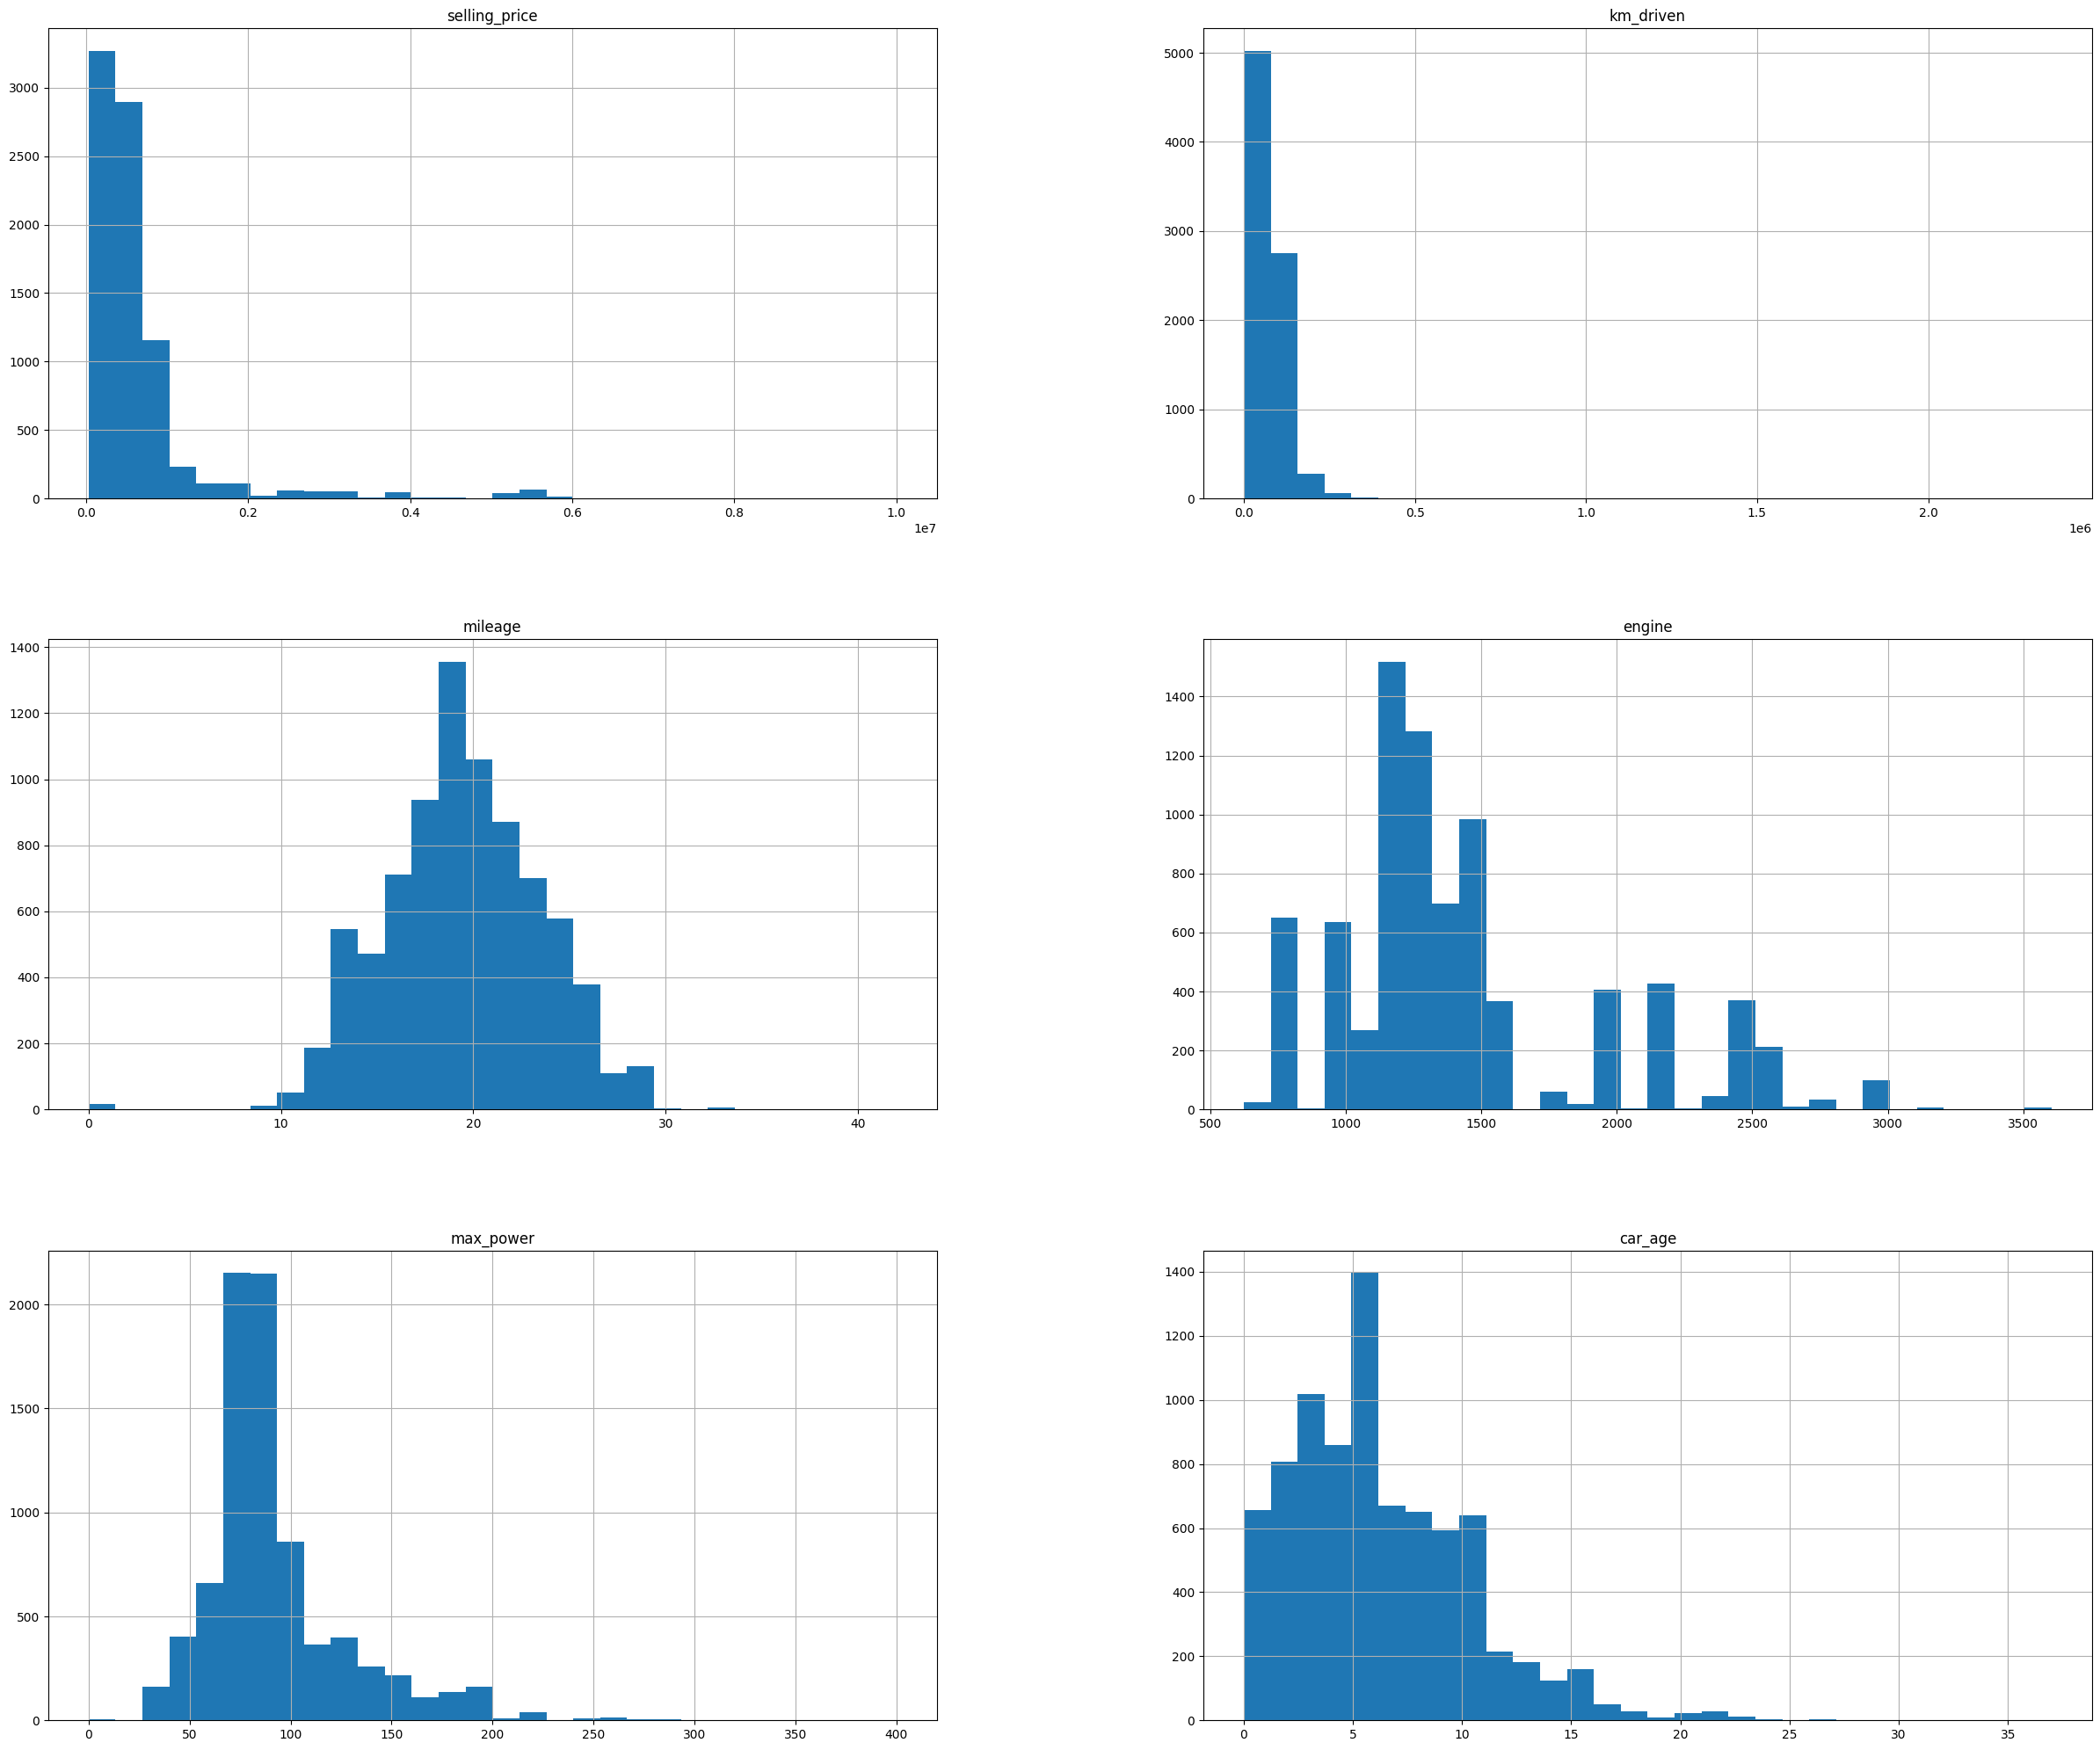

In [22]:
df.hist(figsize = (30, 25), bins = 30, legend = False)
plt.show()

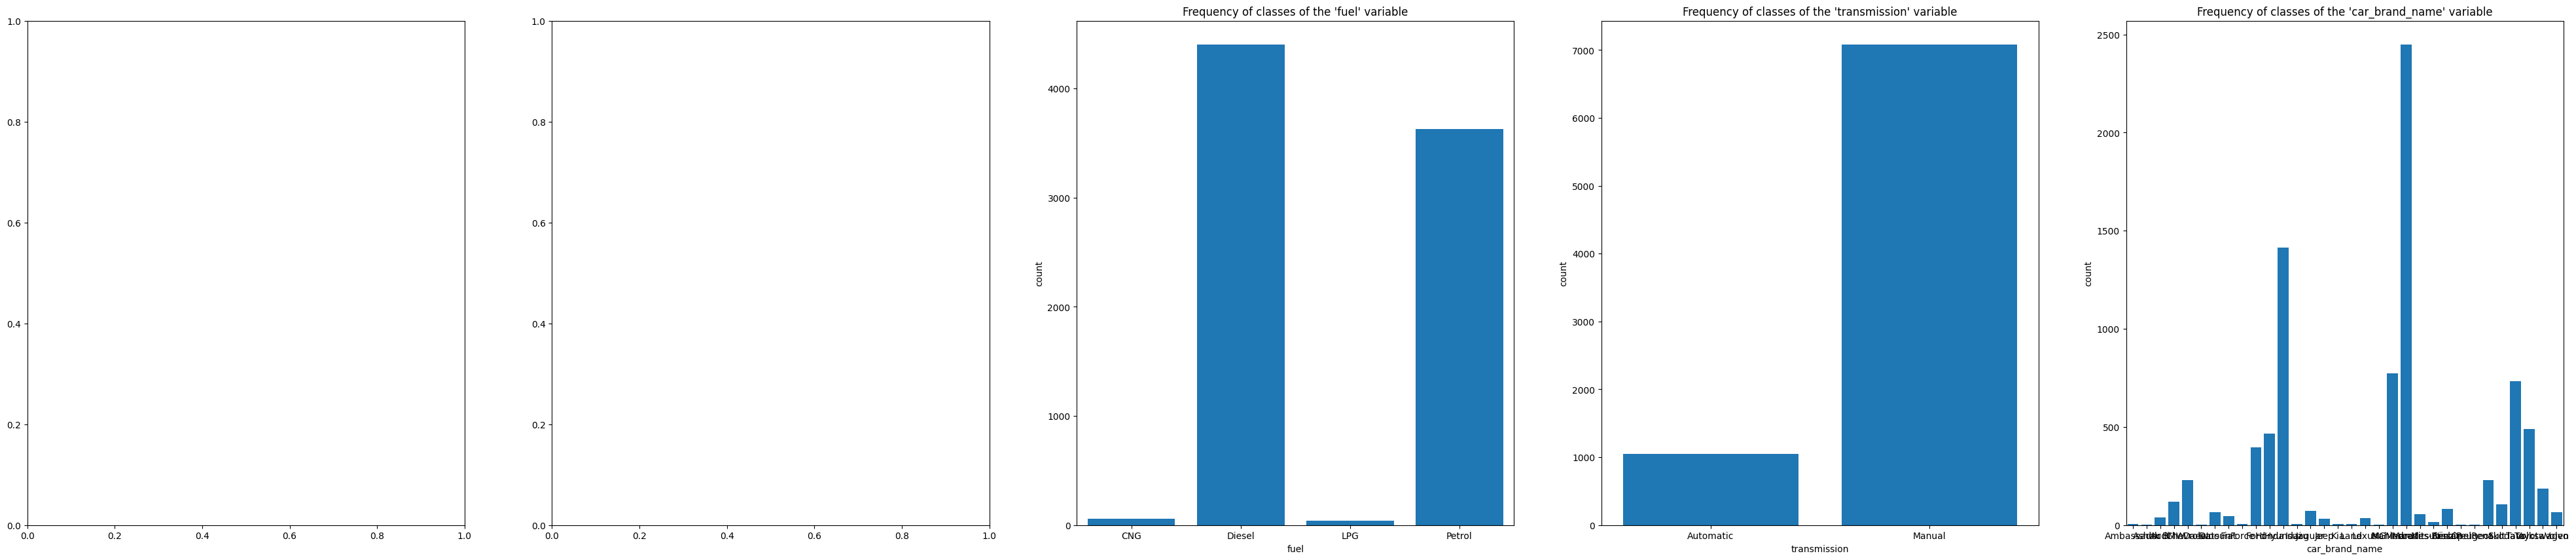

In [23]:
fig, axes = plt.subplots(1, 5, figsize = (50, 10))


sns.barplot(ax = axes[2], x = df["fuel"].value_counts().index, y = df["fuel"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'fuel' variable");

sns.barplot(ax = axes[3], x = df["transmission"].value_counts().index, y = df["transmission"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'transmission' variable");

sns.barplot(ax = axes[4], x = df["car_brand_name"].value_counts().index, y = df["car_brand_name"].value_counts(),
            saturation = 1).set(title = "Frequency of classes of the 'car_brand_name' variable");

#### Plotly express

In [24]:
fig = px.density_heatmap(df, x = "max_power", y = "selling_price", z = "mileage",
                        color_continuous_scale = "deep", text_auto = True,
                        title = "Density heatmap between variables")
fig.show()

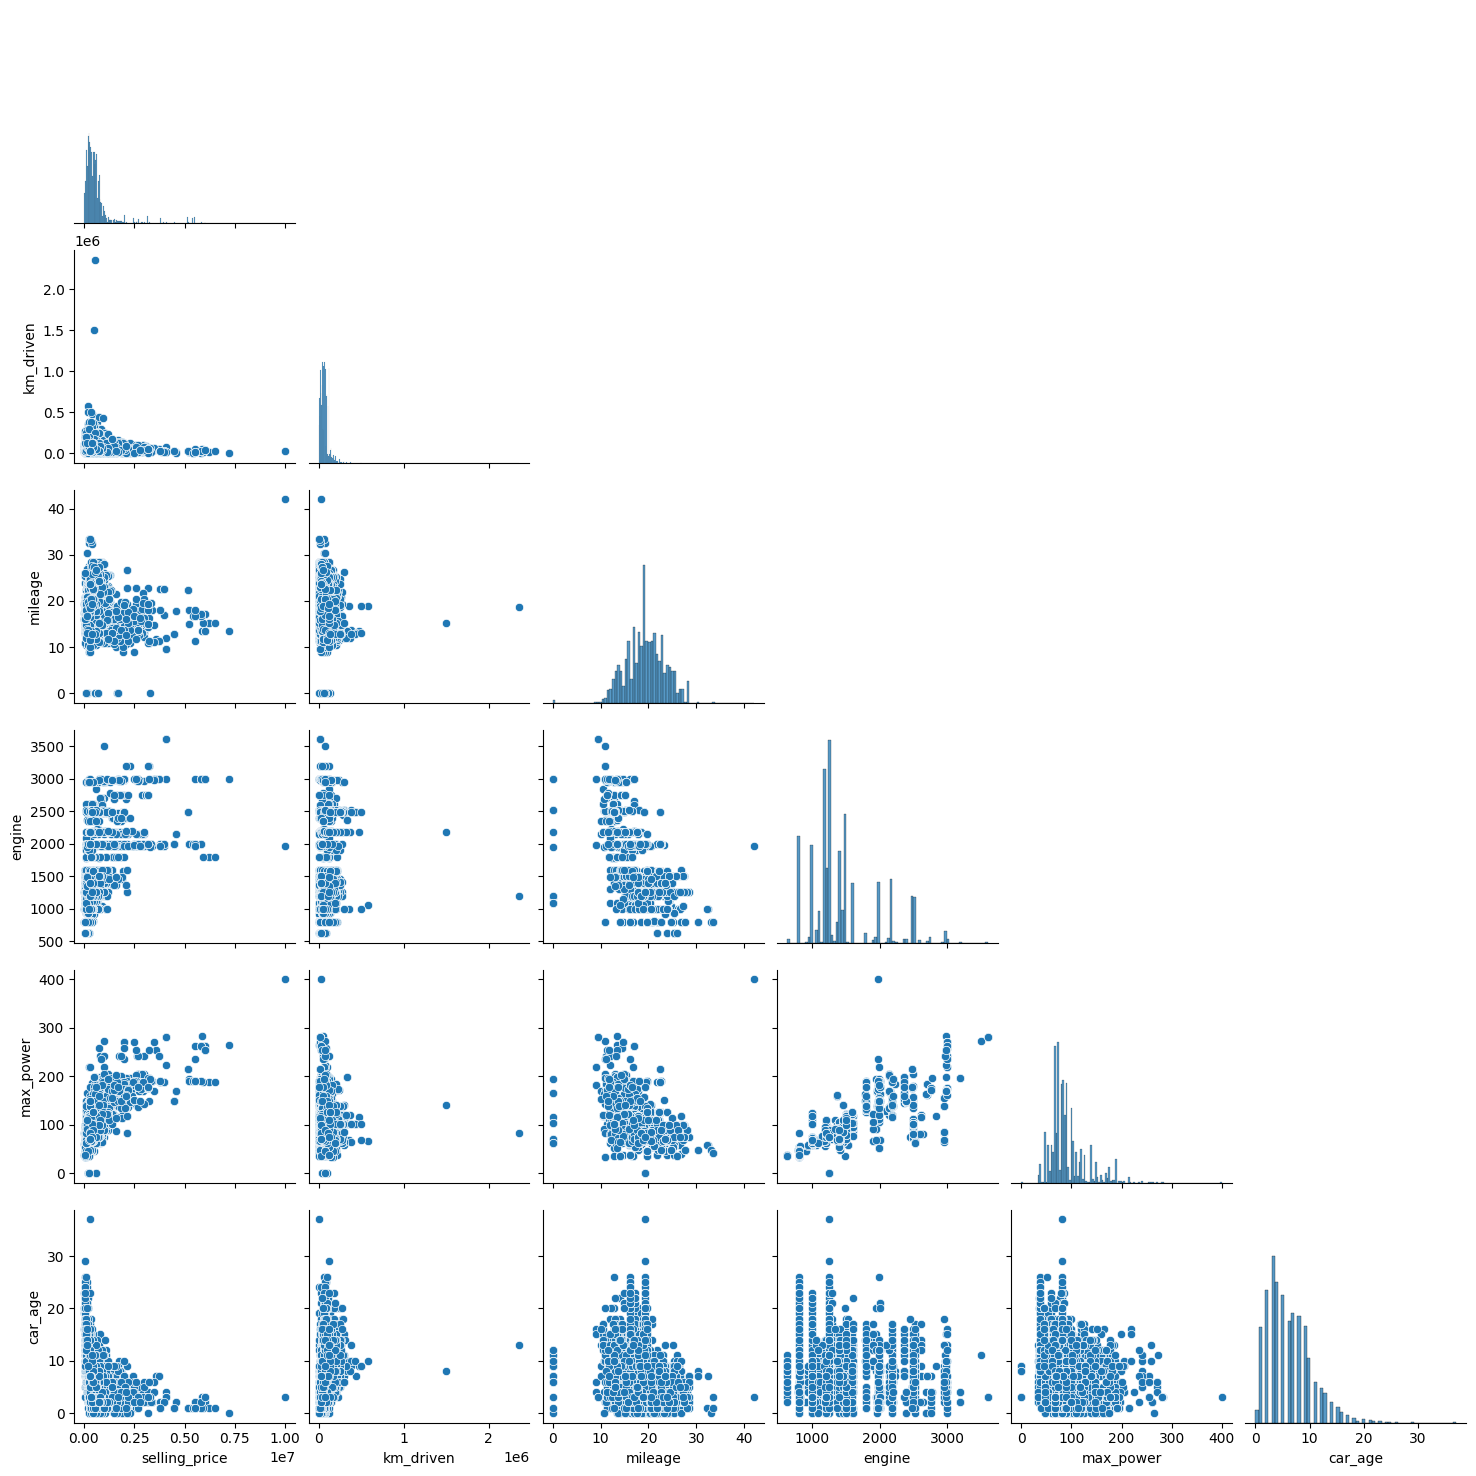

In [25]:
sns.pairplot(df, diag_kind = "hist", corner = True);

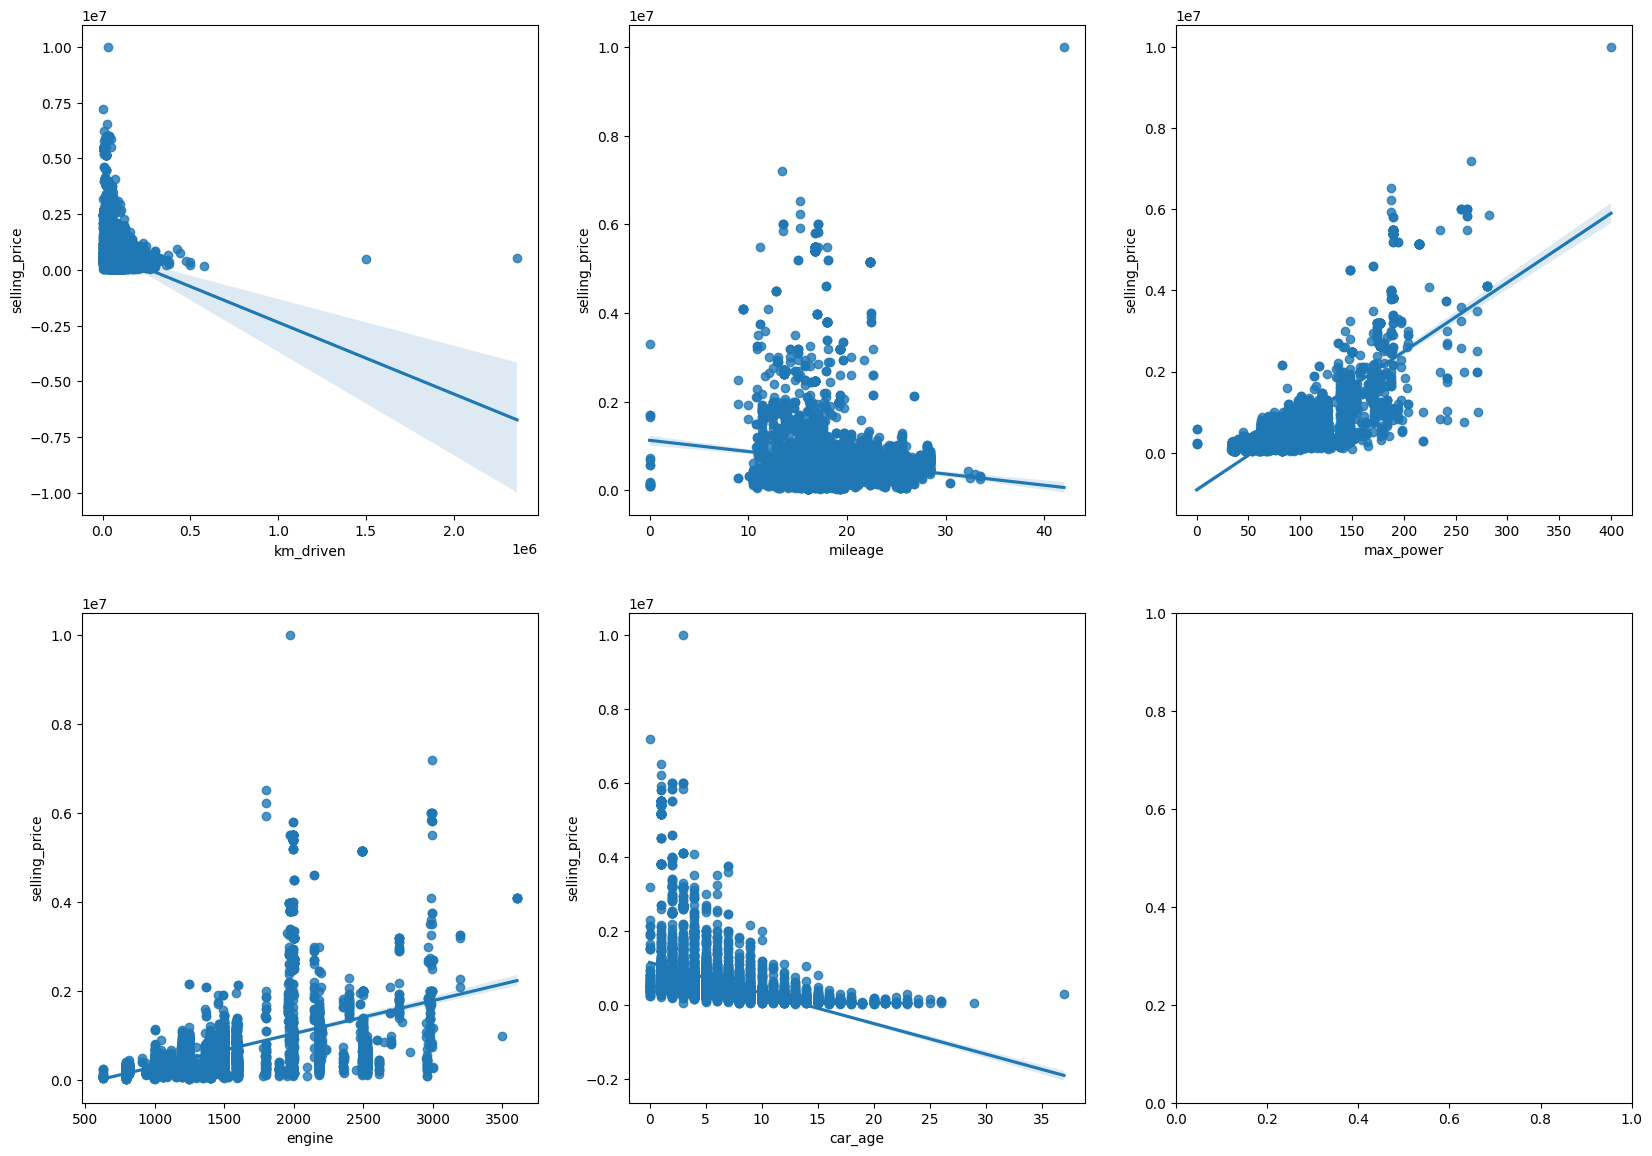

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

sns.regplot(ax = axes[0], x = "km_driven", y = "selling_price", data = df);
sns.regplot(ax = axes[1], x = "mileage", y = "selling_price", data = df);
sns.regplot(ax = axes[2], x = "max_power", y = "selling_price", data = df);
sns.regplot(ax = axes[3], x = "engine", y = "selling_price", data = df);
sns.regplot(ax = axes[4], x = "car_age", y = "selling_price", data = df);

#### Correlation and heatmap

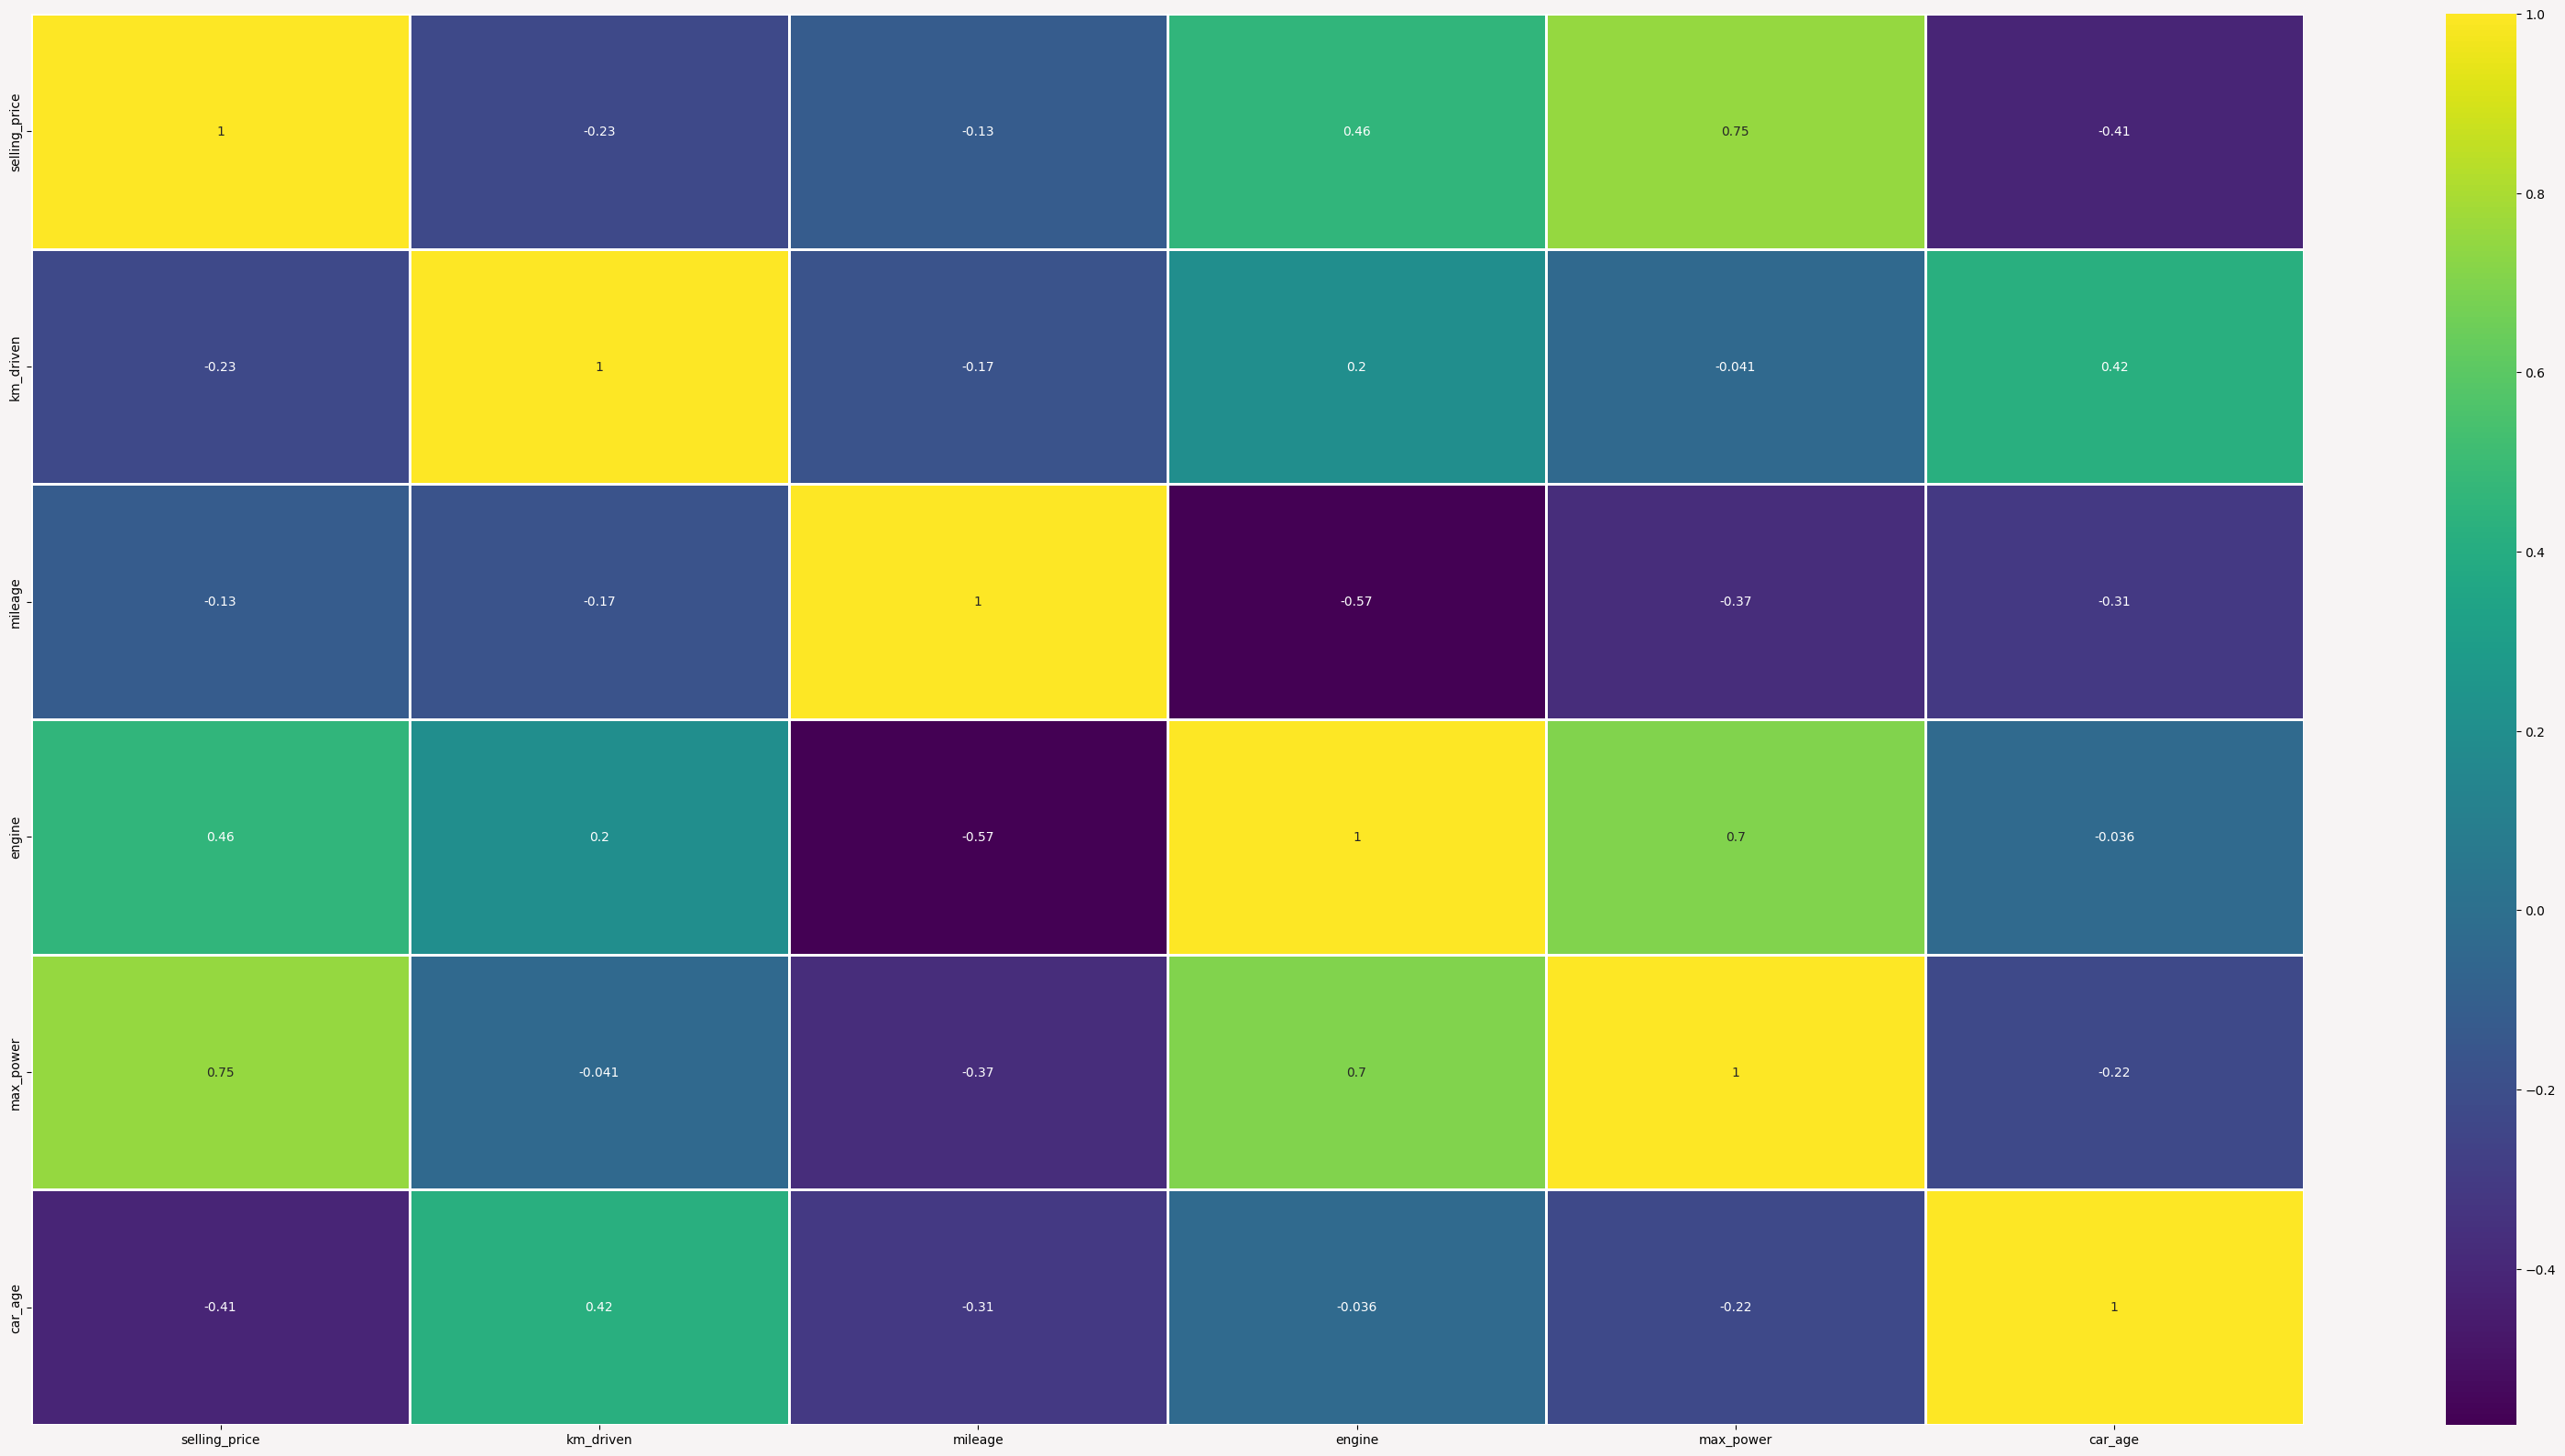

In [27]:
plt.figure(figsize = [40, 20], facecolor = "#F7F4F4")
sns.heatmap(df[numeric_data].corr(), annot = True, linewidths = 2, linecolor = "white", cmap = "viridis");

In [28]:
df[numeric_data].corr()

,selling_price,km_driven,mileage,engine,max_power,car_age
selling_price,1.000000,-0.225534,-0.125040,0.458345,0.747935,-0.414092
km_driven,-0.225534,1.000000,-0.171746,0.198911,-0.040599,0.418006
mileage,-0.125040,-0.171746,1.000000,-0.574128,-0.372897,-0.311657
engine,0.458345,0.198911,-0.574128,1.000000,0.703612,-0.035851
max_power,0.747935,-0.040599,-0.372897,0.703612,1.000000,-0.224704
car_age,-0.414092,0.418006,-0.311657,-0.035851,-0.224704,1.000000


### Target variable

In [29]:
print("Basic descriptive statistics of the target variable - 'selling_price': \n\n",
      df["selling_price"].describe())

Basic descriptive statistics of the target variable - 'selling_price': 

 count    8.128000e+03
mean     6.382718e+05
std      8.062534e+05
min      2.999900e+04
25%      2.549990e+05
50%      4.500000e+05
75%      6.750000e+05
max      1.000000e+07
Name: selling_price, dtype: float64


In [30]:
print("Skewness of target variable: ", df["selling_price"].skew())
print("Kurtosis of target variable: ", df["selling_price"].kurt())

Skewness of target variable:  4.193533440675855
Kurtosis of target variable:  21.081289012186755


In [31]:
# df["selling_price"] = np.log1p(df["selling_price"])
# df["selling_price"].head(n = 10)

In [32]:
# get skewness of other numeric variables

numeric_data = [column for column in df.select_dtypes(["int", "float"])]
for col in numeric_data:
    print("Skewness of", col, "variable is:", df[col].skew())

Skewness of selling_price variable is: 4.193533440675855
Skewness of km_driven variable is: 11.170909783549087
Skewness of mileage variable is: -0.14220847114521287
Skewness of engine variable is: 1.1753055440141613
Skewness of max_power variable is: 1.6595575154307947
Skewness of car_age variable is: 1.072292893616034


In [33]:
df.head()

,selling_price,km_driven,fuel,transmission,mileage,engine,max_power,car_brand_name,car_age
0,450000,145500,Diesel,Manual,23.40,1248.0,74.00,Maruti,6
1,370000,120000,Diesel,Manual,21.14,1498.0,103.52,Skoda,6
2,158000,140000,Petrol,Manual,17.70,1497.0,78.00,Honda,14
3,225000,127000,Diesel,Manual,23.00,1396.0,90.00,Hyundai,10
4,130000,120000,Petrol,Manual,16.10,1298.0,88.20,Maruti,13


In [34]:
# select dependent variable (label)

y = df["selling_price"]

In [35]:
# select independent variable (estimator)
x = df.drop("selling_price", axis = 1)

#encode the variables of the dataset
# x = pd.get_dummies(x, columns=["car_brand_name"], drop_first=True)

# dummy_cols = [col for col in x.columns if col.startswith("car_brand_name_")]
# x[dummy_cols] = x[dummy_cols].astype(int)

car_brand_names = df['car_brand_name'].dropna().unique().tolist()
import json

with open('car_brand_names.json', 'w') as f:
    json.dump(car_brand_names, f)
import pickle

with open('car_brand_names.pkl', 'wb') as f:
    pickle.dump(car_brand_names, f)


In [36]:
y.shape, x.shape

((8128,), (8128, 8))

In [37]:
x.head(n = 7)

,km_driven,fuel,transmission,mileage,engine,max_power,car_brand_name,car_age
0,145500,Diesel,Manual,23.40,1248.0,74.00,Maruti,6
1,120000,Diesel,Manual,21.14,1498.0,103.52,Skoda,6
2,140000,Petrol,Manual,17.70,1497.0,78.00,Honda,14
3,127000,Diesel,Manual,23.00,1396.0,90.00,Hyundai,10
4,120000,Petrol,Manual,16.10,1298.0,88.20,Maruti,13
5,45000,Petrol,Manual,20.14,1197.0,81.86,Hyundai,3
6,175000,LPG,Manual,17.30,1061.0,57.50,Maruti,13


In [38]:
# Split the dataset into x_train (y_train) and x_test (y_test) sets

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 1)
print(x_train.shape)
print(x_test.shape)

(6502, 8)
(1626, 8)


In [39]:
k_fold = KFold(n_splits = 10, random_state = 11, shuffle = True)

In [40]:
def cv_rmse(model, X = x_train):
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring = "neg_mean_squared_error", cv = k_fold))
    return rmse

def rmsle(y, y_pred):
    rmsle = np.sqrt(mean_squared_log_error(y, y_pred, squared = False))
    return rmsle

### Make prediction on test dataset

In [48]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, LassoCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 0. Log-transform columns
log_transform_cols = ["km_driven", "mileage", "engine", "max_power", "car_age"]

# 1. Detect column types
numeric_cols = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = x_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Separate car_brand_name for OHE
categorical_cols = [col for col in categorical_cols if col != "car_brand_name"]
brand_col = ["car_brand_name"]

# 2. Preprocessing pipeline
log_scale_transform = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=True)),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('log_num', log_scale_transform, log_transform_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
    ('brand', OneHotEncoder(handle_unknown='ignore', sparse_output=False), brand_col)
])

# 3. Base learners
base_models = [
    ('xgb', XGBRegressor(n_estimators=500, learning_rate=0.1, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=300, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=300, random_state=42)),
    ('lasso', LassoCV(alphas=[
        1e-10, 1e-8, 1e-7, 1e-5, 1e-2, 9e-4, 9e-3,
        5e-4, 3e-4, 1e-4, 1e-3, 1e-2, 0.1,
        0.3, 0.6, 1, 3, 5, 7, 14, 18, 25, 30,
        45, 50, 70, 90
    ], n_jobs=-1, cv=5))
]

# 4. Meta model
meta_model = Ridge(alpha=1.0)

# 5. Stacking Regressor
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# 6. Pipeline
stacking_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', stacking_model)
])

# 7. Log-transform y
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)  # optional, if you want to compare log space R²

# 8. Fit the model
stacking_pipeline.fit(x_train, y_train_log)

# 9. Predict and reverse log
preds_log = stacking_pipeline.predict(x_test)
preds = np.expm1(preds_log)

# 10. Evaluate
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, preds)

print("\n📊 Stacking Regressor Evaluation:")
print(f"MAE: ₹{mae:,.2f}")
print(f"MSE: {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")



with open('stacking_model.pkl', 'wb') as f:
    pickle.dump(stacking_pipeline, f)



📊 Stacking Regressor Evaluation:
MAE: ₹65,293.70
MSE: 12,170,518,380.02
RMSE: 110,320.07
R² Score: 0.9753


Text(0, 0.5, 'prediction')

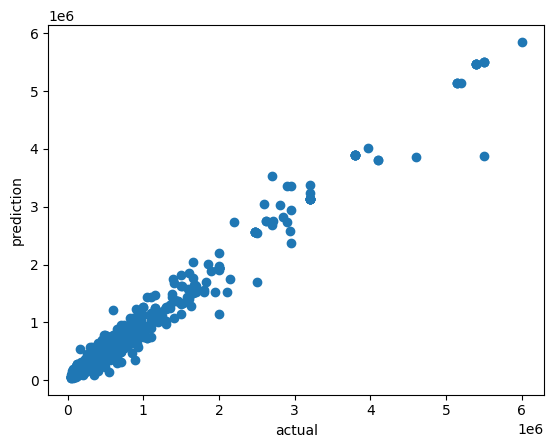

In [49]:
plt.scatter(y_test, preds);
plt.xlabel("actual")
plt.ylabel("prediction")


In [50]:
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, preds)))
print('R-squared: {}'.format(metrics.r2_score(y_test, preds)))

Mean Absolute Error: 65293.696294462294
Mean Squared Error: 12170518380.02081
Root Mean Squared Error: 110320.07242574131
R-squared: 0.9752567519929339
